In [2]:
#disabe annoying warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, reciprocal_rank
from scipy.sparse import coo_matrix
import numpy as np
import joblib 
from tqdm import tqdm 
import matplotlib.pyplot as plt

In [3]:
file_path = '/Users/giulia/Desktop/tesi/data/mind.inter'
data = pd.read_csv(file_path, sep='\t', header=0, names=['user_id', 'item_id', 'label'])
def map_data(data):         #without item/user features, for now
    dataset = Dataset()
    dataset.fit((x.user_id for x in data.itertuples()), 
            (x.item_id for x in data.itertuples()))
    # dataset.fit_partial(items=(x.item_feature for x in data.itertuples()),            #for user/item features, later
    #                     users=(x.user_feature for x in data.itertuples()))
    user_mappings = dataset.mapping()[0]
    item_mappings = dataset.mapping()[2]
    inv_user_mappings = {v:k for k, v in user_mappings.items()}
    inv_item_mappings = {v:k for k, v in item_mappings.items()}
    return dataset, [user_mappings, item_mappings, inv_user_mappings, inv_item_mappings]

dataset, _ = map_data(data)

In [3]:
train = pd.read_csv('data/train', sep='\t', header=0)
test = pd.read_csv('data/test', sep='\t', header=0)
val = pd.read_csv('data/val', sep='\t', header=0)
train_interactions, _w1 = dataset.build_interactions(((x.user_id, x.item_id, x.label) for x in train.itertuples()))
val_interactions, _w2 = dataset.build_interactions(((x.user_id, x.item_id, x.label) for x in val.itertuples()))
test_interactions, _w3 = dataset.build_interactions(((x.user_id, x.item_id, x.label) for x in test.itertuples()))
# user_features = dataset.build_user_features((x.user_id, [x.user_feature]) for x in data.itertuples())
# item_features = dataset.build_item_features((x.item_id, [x.item_feature]) for x in data.itertuples())

In [ ]:
learning_rates = [0.005, 0.01, 0.05]    #grid search
no_components = [20, 40, 80]
loss_functions = ['bpr', 'warp']
max_sampled = 3

epochs = 10
patience = 3
k = 5

best_params = {}
best_val_precision = 0
best_epoch = 0


results = []

for loss in loss_functions:
    for learning_rate in learning_rates:
        for no_component in no_components:
            model = LightFM(loss=loss, learning_rate=learning_rate, no_components=no_component, max_sampled=max_sampled, random_state=42)
            patience_counter = 0
            local_best_precision = 0

            for epoch in tqdm(range(epochs), desc=f'Training {loss}-{learning_rate}-{no_component}'):
                model.fit_partial(train_interactions, epochs=1, num_threads=4)
                train_precision = precision_at_k(model, train_interactions, k=k).mean()
                val_precision = precision_at_k(model, val_interactions, k=k).mean()
                print(f'Epoch {epoch + 1}/{epochs} for config {loss}-{learning_rate}-{no_component}')
                print(f'Training Precision@{k}: {train_precision} | Validation Precision@{k}: {val_precision}')

                if val_precision > local_best_precision:
                    local_best_precision = val_precision
                    patience_counter = 0
                    if val_precision > best_val_precision:
                        best_val_precision = val_precision
                        best_params = {'loss': loss, 'learning_rate': learning_rate, 'no_components': no_component}
                        best_epoch = epoch + 1
                        
                        model_filename = f'data/best_model/best_model_{loss}_{learning_rate}_{no_component}.pkl'
                        joblib.dump(model, model_filename)
                        print(f'Saved new best model for config {loss}-{learning_rate}-{no_component} at epoch {epoch + 1}')
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f'Early stopping for config {loss}-{learning_rate}-{no_component} at epoch {epoch + 1}')
                    break
            
            results.append({
                'loss': loss,
                'learning_rate': learning_rate,
                'no_components': no_component,
                'best_precision': local_best_precision,
                'epoch': epoch + 1
            })

print(f'Best validation precision achieved with config {best_params} at epoch {best_epoch}: {best_val_precision}')
print('All results:', results)

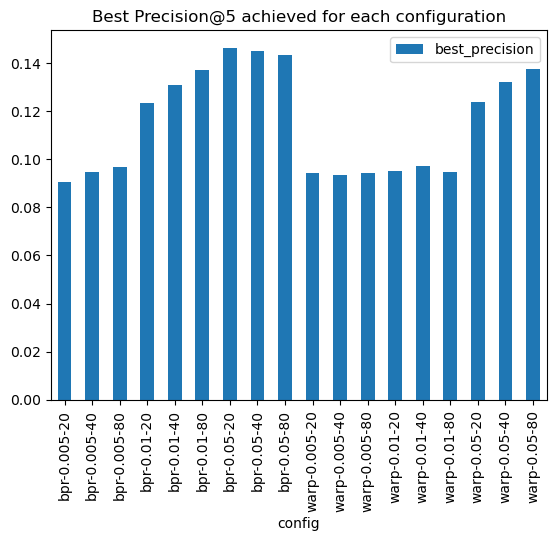

In [7]:
results_df = pd.DataFrame(results)
results_df['config'] = results_df['loss'] + '-' + results_df['learning_rate'].astype(str) + '-' + results_df['no_components'].astype(str)
results_df.plot(x='config', y='best_precision', kind='bar', title='Best Precision@5 achieved for each configuration')
plt.show()

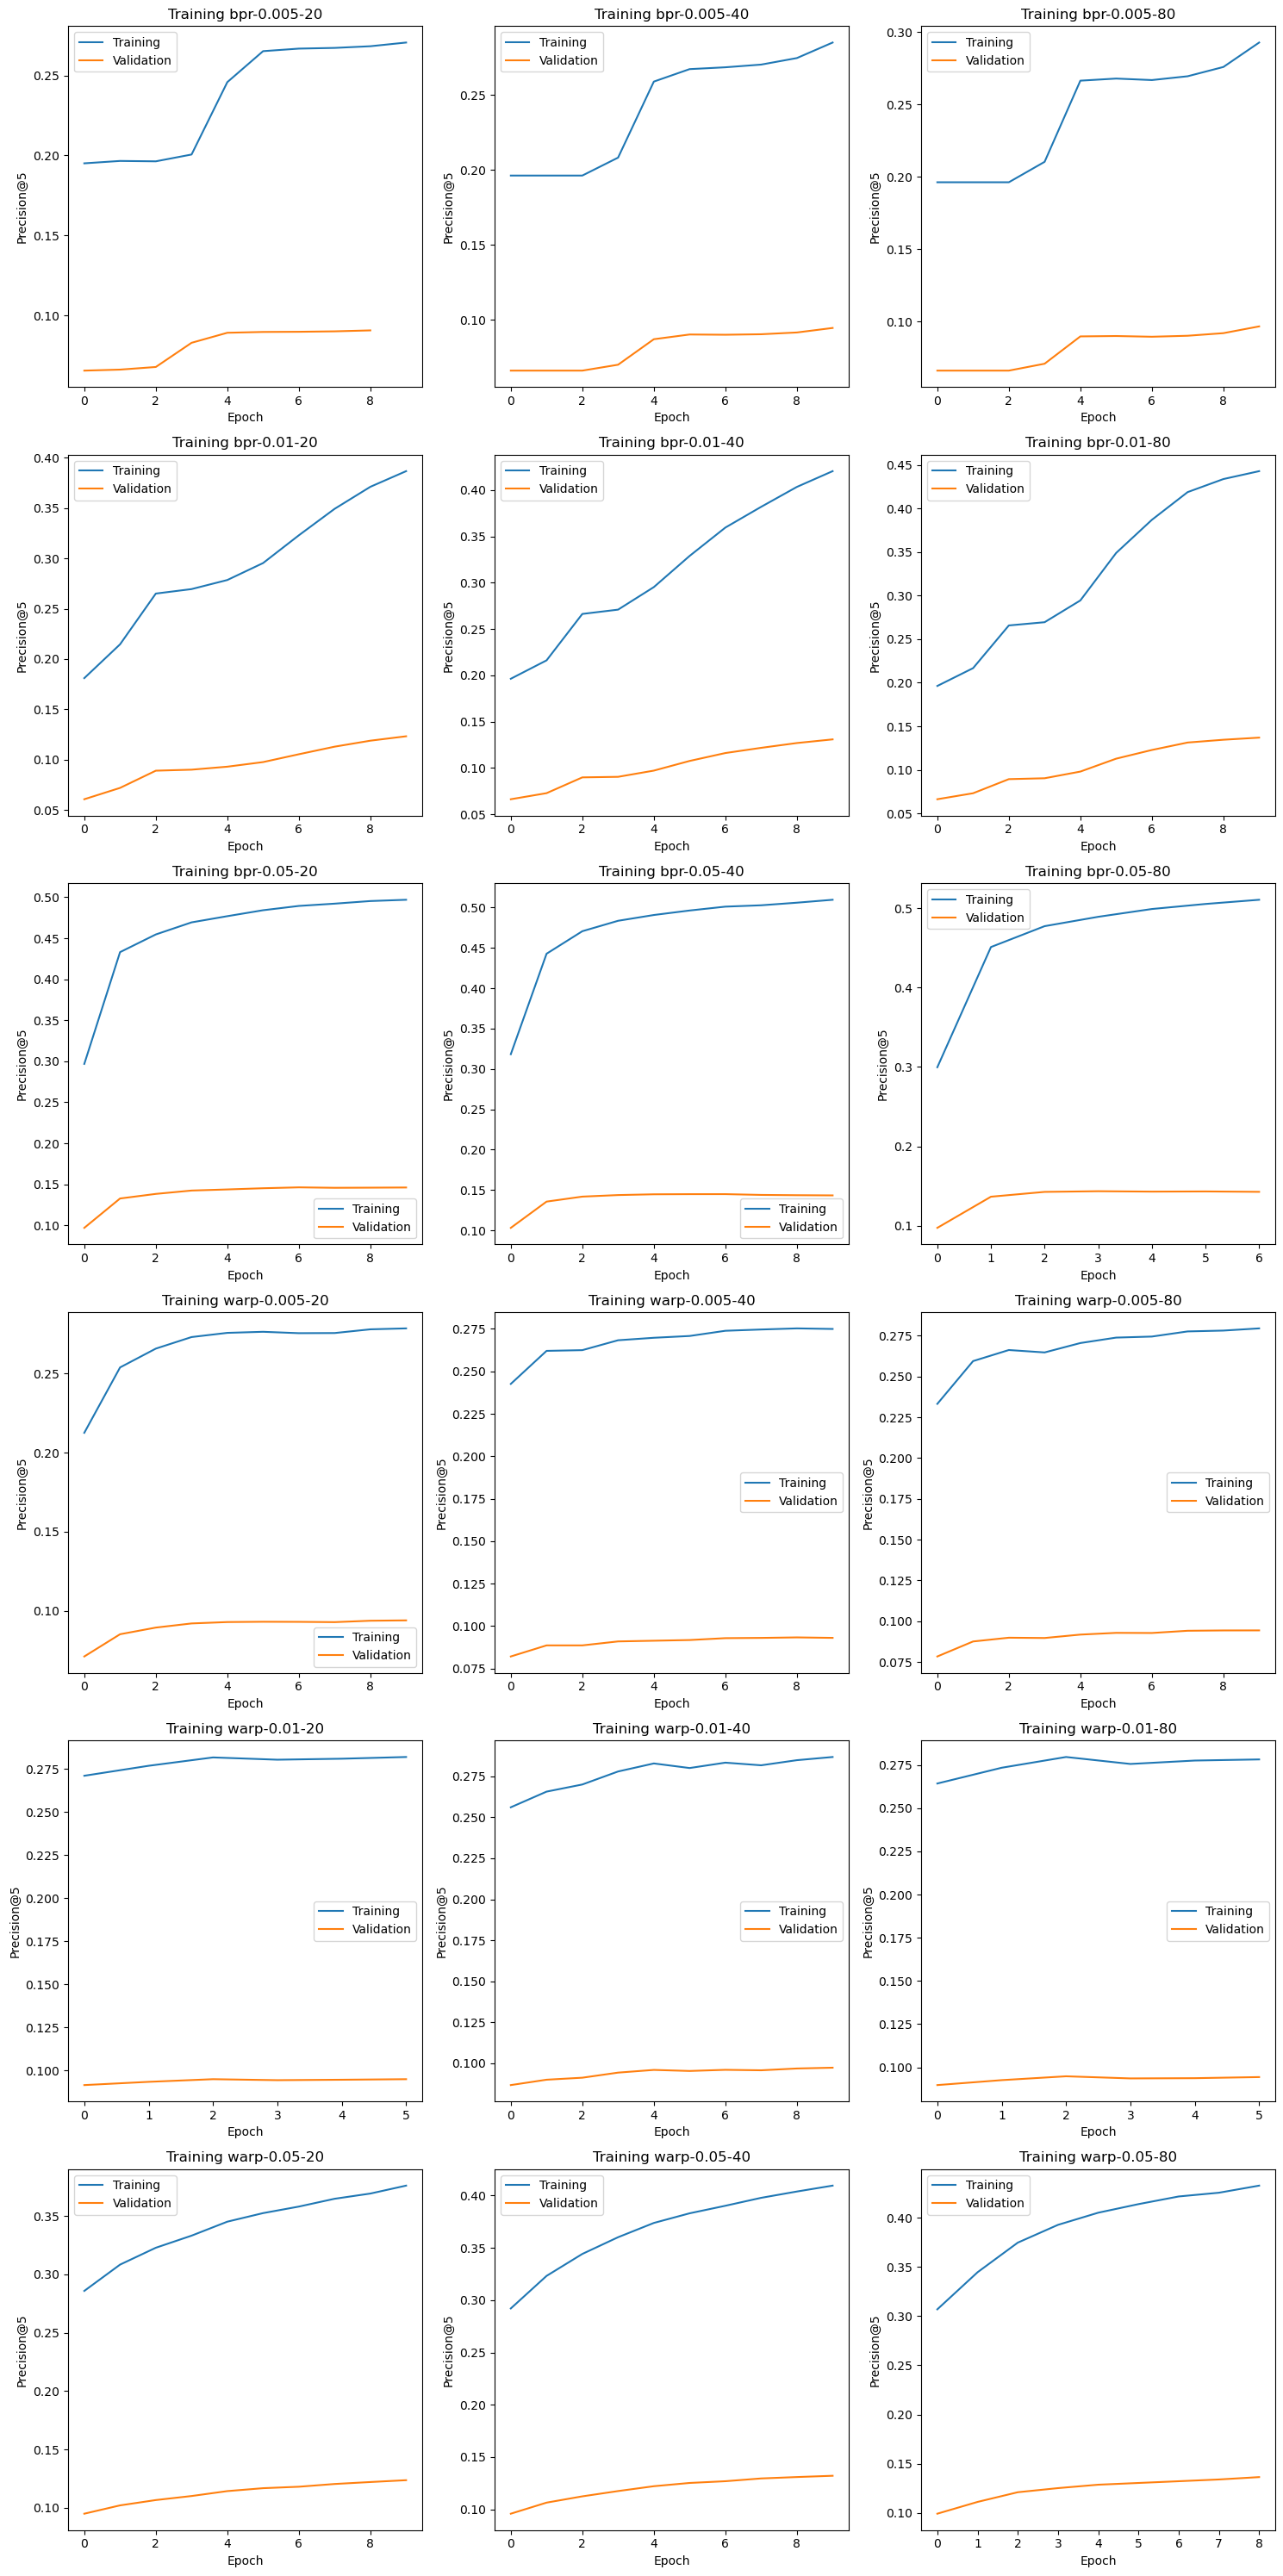

In [11]:
num_models = len(results)
rows = (num_models + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows)) 
axes = axes.flatten()
for idx, (key, data) in enumerate(results.items()):
    ax = axes[idx]
    ax.plot(data['Training Precision@5'], label='Training')
    ax.plot(data['Validation Precision@5'], label='Validation')
    ax.set_title(key)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Precision@5')
    ax.legend()
for ax in axes[num_models:]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

----------------------------------------------------------------------------------------------------------------
second grid search (precision@5 on validation set): <br> 
**lr**: 0.005 and 0.01 slow but consistent learning, 0.05 too big, fast but stuck around epoch 7<br>
**loss**: no big differences <br>
**num_factors**: overrall 80 better than 40, 40 better than 20<br>

| Epoch | bpr-0.005-20 | bpr-0.005-40 | bpr-0.005-80 | bpr-0.01-20 | bpr-0.01-40 | bpr-0.01-80 | bpr-0.05-20 | **<font color='red'>bpr-0.05-40</font>** | **<font color='red'>bpr-0.05-80</font>** | warp-0.005-20 | warp-0.005-40 | warp-0.005-80 | warp-0.01-20 | warp-0.01-40 | warp-0.01-80 | warp-0.05-20 | warp-0.05-40 | **<font color='red'>warp-0.05-80</font>** |
|-------|--------------|--------------|--------------|-------------|-------------|-------------|-------------|-------------|-------------|---------------|---------------|---------------|--------------|--------------|--------------|--------------|--------------|--------------|
| 1     | 0.07334      | 0.06564      | 0.06492      | 0.07138     | 0.06979     | 0.06704     | 0.14255     | 0.14217     | 0.15007     | 0.08981       | 0.09877       | 0.08570       | 0.10576      | 0.11303      | 0.11714      | 0.14055      | 0.15008      | 0.15699      |
| 2     | 0.07257      | 0.07283      | 0.06842      | 0.11511     | 0.11742     | 0.11734     | 0.16365     | 0.17381     | 0.18441     | 0.09128       | 0.10728       | 0.08856       | 0.11404      | 0.11930      | 0.12194      | 0.15229      | 0.16565      | 0.17466      |
| 3     | 0.09281      | 0.10968      | 0.10992      | 0.12171     | 0.12415     | 0.12572     | 0.17428     | 0.18576     | 0.19163     | 0.09378       | 0.11133       | 0.09270       | 0.11795      | 0.12392      | 0.12617      | 0.15849      | 0.17370      | 0.18210      |
| 4     | 0.11346      | 0.11789      | 0.11827      | 0.12806     | 0.13181     | 0.13659     | 0.18048     | 0.19008     | 0.19351     | 0.09557       | 0.11465       | 0.09889       | 0.12189      | 0.12627      | 0.13006      | 0.16284      | 0.17823      | 0.18610      |
| 5     | 0.11699      | 0.11909      | 0.12137      | 0.13499     | 0.13829     | 0.14303     | 0.18338     | 0.19136     | 0.19490     | 0.09756       | 0.11545       | 0.10438       | 0.12366      | 0.12662      | 0.13285      | 0.16630      | 0.18116      | 0.18933      |
| 6     | 0.11946      | 0.12154      | 0.12455      | 0.13841     | 0.14190     | 0.14919     | 0.18550     | 0.19257     | 0.19464     | 0.10105       | 0.11601       | 0.11064       | 0.12498      | 0.12858      | 0.13561      | 0.16854      | 0.18278      | 0.19080      |
| 7     | 0.12168      | 0.12393      | 0.12880      | 0.14193     | 0.14519     | 0.15380     | 0.18610     | 0.19284     | 0.19436     | 0.10412       | 0.11712       | 0.11625       | 0.12646      | 0.13046      | 0.13718      | 0.17046      | 0.18457      | 0.19217      |
| 8     | 0.12377      | 0.12726      | 0.13271      | 0.14462     | 0.14831     | 0.15855     | 0.18667     | 0.19263     | 0.19404     | 0.10533       | 0.11826       | 0.11887       | 0.12779      | 0.13264      | 0.13958      | 0.17236      | 0.18617      | 0.19238      |
| 9     | 0.12590      | 0.13027      | 0.13663      | 0.14635     | 0.15134     | 0.16282     | 0.18688     | 0.19199     | -     | 0.10787       | 0.11961       | 0.12160       | 0.12931      | 0.13381      | 0.14149      | 0.17375      | 0.18669      | 0.19324      |
| 10    | 0.12926      | 0.13307      | 0.13961      | 0.14828     | 0.15394     | 0.16661     | 0.18686     | 0.19159     | -     | 0.10931       | 0.12094       | 0.12195       | 0.12994      | 0.13461      | 0.14248      | 0.17467      | 0.18824      | 0.19404      |


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#old code w/ old datasplit

First grid search results (precision@5 on val set):


| Epoch | bpr-0.001-20 | bpr-0.001-40 | bpr-0.001-80 | bpr-0.005-20 | bpr-0.005-40 | bpr-0.005-80 | bpr-0.01-20 | bpr-0.01-40 | bpr-0.01-80 | warp-0.001-20 | warp-0.001-40 | warp-0.001-80 | warp-0.005-20 | warp-0.005-40 | warp-0.005-80 | warp-0.01-20 | warp-0.01-40 | warp-0.01-80 |
|-------|--------------|--------------|--------------|--------------|--------------|--------------|-------------|-------------|-------------|---------------|---------------|---------------|---------------|---------------|---------------|--------------|--------------|--------------|
| 1     | 0.03539      | 0.03504      | 0.03539      | 0.03539      | 0.03504      | 0.03539      | 0.03540     | 0.03544     | 0.03541     | 0.03573       | 0.03608       | 0.03679       | 0.03614       | 0.03732       | 0.03612       | 0.03673      | 0.03976      | 0.03657      |
| 2     | 0.03539      | 0.03545      | 0.03539      | 0.03540      | 0.03540      | 0.03552      | 0.03571     | 0.03593     | 0.03573     | 0.03578       | 0.03695       | 0.03768       | 0.03675       | 0.03717       | 0.03672       | 0.03899      | 0.04020      | 0.03928      |
| 3     | 0.03539      | 0.03541      | 0.03539      | 0.03542      | 0.03543      | 0.03545      | 0.03836     | 0.03941     | 0.04052     | 0.03572       | 0.03729       | 0.03666       | 0.03652       | 0.03798       | 0.03968       | 0.03897      | 0.03722      | 0.03716      |
| 4     | 0.03539      | 0.03541      | 0.03539      | 0.03563      | 0.03592      | 0.03626      | 0.04167     | 0.04283     | 0.04406     | 0.03557       | 0.03772       | 0.03610       | 0.03629       | 0.04114       | 0.04036       | 0.03823      | 0.04096      | 0.04023      |
| 5     | -            | 0.03539      | -            | 0.03614      | 0.03708      | 0.03804      | 0.04446     | 0.04671     | 0.04863     | 0.03545       | 0.03774       | 0.03572       | 0.03620       | 0.04114       | 0.04025       | 0.03742      | 0.04140      | 0.04102      |
| 6     | -            | -            | -            | 0.03713      | 0.03860      | 0.03968      | 0.04756     | 0.05026     | 0.05258     | -             | 0.03768       | -             | -             | 0.04010       | 0.03751       | -            | 0.03797      | 0.04119      |   |
| 7     | -            | -            | -            | 0.03828      | 0.03972      | 0.04162      | 0.04953     | 0.05229 | 0.05504	|            - |     0.03747 | - | - | 0.04102 | 0.04012 | - | 0.03861 | 0.04368
| 8     | -            | -            | -            | 0.03925      | 0.04098     | 0.04293      | 0.05085     | 0.05412 | 0.05750 | - | 0.03732 |-|-|0.04073|-|-|0.03862| 0.04190
| 9     | -            | -            | -            | 0.04046     | 0.04199      | 0.04443      | 0.05230	     | 0.05579 | 0.05931 | -| -|-|-|-|-|-|-| 0.04328
| 10    | -            | -            | -            | 0.04137      | 0.04339      | 0.04608      | 0.05354     | 0.05738 | **<font color='red'>0.06121</font>** | -| -|-|-|-|-|-|-|0.04296

In [ ]:
best_model = joblib.load(f'best_model_bpr_0.01_80.pkl')
val_recall = recall_at_k(best_model, val_interactions, k=5).mean()
val_auc = auc_score(best_model, val_interactions).mean()
print(f'Validation Recall@{k}: {val_recall}, Validation AUC: {val_auc}') #9 min

Validation Recall@5: 0.011959579800440531, Validation AUC: 0.3448621928691864


Sources: [LightFM doc](https://making.lyst.com/lightfm/docs/home.html#:~:text=LightFM%20is%20a%20Python%20implementation,the%20traditional%20matrix%20factorization%20algorithms.) - [example](https://www.stepbystepdatascience.com/hybrid-recommender-lightfm-python) -[kaggle_ex1_](https://www.kaggle.com/code/parthplc/interview-building-recommendation-system-lightfm) - [kaggle_ex2](https://www.kaggle.com/code/niyamatalmass/lightfm-hybrid-recommendation-system) -[githubissue](https://github.com/lyst/lightfm/issues/229)